# Antibody CDR loop conformational change analysis before and after complexation

### Glossary
1. Unbound or Free antibody structures: are antibody structures before complexation with antigen, extracted from Ab pdb file
2. Bound or Complexed antibody structures: are antibody structures after complexation with antigen, extracted from AbAg complex pdb file

In [1]:
import json
import re

import scipy

from cdr_analysis_tools import *
%matplotlib inline

## Functions

In [2]:
def plot_cdr_rmsd_violin(df: pd.DataFrame,
                         col_names=None,
                         title: str = None,
                         xlabel: str = None,
                         ylabel: str = None,
                         size=None,
                         save_fig_name: str = None):
    fig = go.Figure()

    if not col_names:
        col_names = [f"{i}_rmsd" for i in 'fr,l1,l2,l3,h1,h2,h3'.split(',')]

    for col in col_names:
        fig.add_trace(go.Violin(y=df[col],
                                name=col,
                                box_visible=True,
                                meanline_visible=True))
    fig.update_layout(
        title=dict(text=title, x=0.5, y=0.9, xanchor='center', yanchor='top', font=dict(size=15), ),
        xaxis=dict(title=xlabel, ),
        yaxis=dict(title=ylabel, ),
        showlegend=True, )
    fig.update_layout(width=size[0], height=size[1]) if size else fig.update_layout(width=None, height=None)

    # show figure
    iplot(fig)

    # save figure
    if save_fig_name:
        os.makedirs('plots', exist_ok=True)
        fig.write_image(f"plots/{save_fig_name}.png")
        fig.write_image(f"plots/{save_fig_name}.pdf")

def get_plot_name(binder_type: str,
                  filter: bool,
                  weight: bool,
                  plot_name: str):
    s = [binder_type]
    s.append("filtered") if filter else s.append("unfiltered")
    if weight: s.append("weighted")
    s.append(plot_name)
    s = '.'.join(s)

    return s

def get_plot_title(binder_type: str,
                   filter: bool,
                   plot_name: str):
    s = []
    s.append("Filtered") if filter else s.append("Unfiltered")
    s.append(binder_type)
    s.append(plot_name)
    s = ' '.join(s)
    return s

## Main

In [19]:
CDR= 'fr,l1,l2,l3,h1,h2,h3'.split(',')
BASE = "/Users/chunan/UCL/scripts/ab-docking-scripts/chunan"  # change this path accordingly
try:
    assert os.path.isdir(BASE)
except AssertionError:
    raise NotADirectoryError(f"Did not find BASE directory: {BASE}")

OUT = os.path.join(BASE, "output")  # directory to save plots and intermediate files
DATA = os.path.join(BASE, "data")  # directory of input data

load profit antibody structure alignment results

### Load results.json

In [21]:
# load profit results
file = os.path.join(DATA, "20220324.24Mar2022.ProFit.onVHVLseparately", "results.json")
with open(file, 'r') as f:
    data = json.load(f)

### Read results.json as pd.DataFrame

Data: RMSDs of CDR loops for each unbound/bound ab pair

parse json data object (dict)

In [22]:
# categorical
line_id_list, ub_name_list =[], []
# numerical
ub_num_atm_aln_list = []
ub_rmsd_list = []
ub_angle_dif_list = []

for line_id, v1 in data.items():
    abpa = v1['abpackingangle']['unbound']
    abpa.update(v1['abpackingangle']['bound'])
    for ub_name, v2 in v1['ub'].items():
        line_id_list.append(int(line_id))
        ub_name_list.append(ub_name)
        # Superimpose FR: FR, L1, L2, L3, H1, H2, H3
        rmsd = [v2['rmsd'][k] for k in
                ['FR'] + [f'{c}{i}' for c in ('H', 'L') for i in range(1, 4)] +
                ['H_FR'] + [f'H_H{i}' for i in range(1, 4)] +
                ['L_FR'] + [f'L_L{i}' for i in range(1, 4)]]
        # num_atm_aln = list(v2['num_atm_aln'].values())
        num_atm_aln = [v2['num_atm_aln'][k] for k in
                       ['FR', 'H_FR', 'L_FR'] + [f'{c}{i}' for c in ('H', 'L') for i in range(1, 4)]]
        ub_rmsd_list.append(rmsd)
        ub_num_atm_aln_list.append(num_atm_aln)
        # ab packing angle
        try:
            a_dif = abs(abpa[ub_name[:6]]-abpa[ub_name[-6:]])
        except:
            a_dif = None
        ub_angle_dif_list.append(a_dif)

ub_rmsd = np.array(ub_rmsd_list)  # [fr_rmsd, h_rmsd, l_rmsd, h1_rmsd, h2_rmsd, h3_rmsd, l1_rmsd, l2_rmsd, l3_rmsd, h_h1, h_h2, h_h3, l_l1, l_l2, l_l3]
ub_num_atm_aln = np.array(ub_num_atm_aln_list, dtype=np.int32)  # [fr, h_fr, l_fr, h1, h2, h3, l1, l2, l3]
ub_angle_dif = np.array(ub_angle_dif_list, dtype=np.float64)

convert to pandas DataFrame

In [23]:
ub_df = pd.DataFrame(columns=[
    'line_id', 'ub_name',
    # superimpose hl framework, cols: [2:11]
    'fr_rmsd',
    'h1_rmsd', 'h2_rmsd', 'h3_rmsd',
    'l1_rmsd', 'l2_rmsd', 'l3_rmsd',
    # superimpose H framework, cols: [11:14]
    'h_rmsd', 'h_h1_rmsd', 'h_h2_rmsd', 'h_h3_rmsd',
    # superimpose L framework, cols: [14:17]
    'l_rmsd', 'l_l1_rmsd', 'l_l2_rmsd', 'l_l3_rmsd',
    # packing angle difference, col [17]
    'angle_dif',
    # num_atm_aln, cols: [18:27]
    'fr_num_atm_aln', 'h_num_atm_aln', 'l_num_atm_aln',
    'h1_num_atm_aln', 'h2_num_atm_aln', 'h3_num_atm_aln',
    'l1_num_atm_aln', 'l2_num_atm_aln', 'l3_num_atm_aln',])

ub_df['line_id'] = line_id_list
ub_df['ub_name'] = ub_name_list
ub_df.iloc[:, 2:17] = ub_rmsd
ub_df.iloc[:, 17] = ub_angle_dif
ub_df.iloc[:, 18:27] = ub_num_atm_aln

### cleaning
There exists cases whose the number of aligned CDR loop CA atoms greater than 100.

Cause: missing CDR loop atoms

In [24]:
print('l1_num_atm_aln > 100:', ub_df[ub_df.l1_num_atm_aln>50].shape[0])
print('l2_num_atm_aln > 100:', ub_df[ub_df.l2_num_atm_aln>50].shape[0])
print('l3_num_atm_aln > 100:', ub_df[ub_df.l3_num_atm_aln>50].shape[0])
print('h1_num_atm_aln > 100:', ub_df[ub_df.h1_num_atm_aln>50].shape[0])
print('h2_num_atm_aln > 100:', ub_df[ub_df.h2_num_atm_aln>50].shape[0])
print('h3_num_atm_aln > 100:', ub_df[ub_df.h3_num_atm_aln>50].shape[0])

print(ub_df[ub_df.l3_num_atm_aln>50].ub_name)
print(ub_df[ub_df.h3_num_atm_aln>50].ub_name)

l1_num_atm_aln > 100: 0
l2_num_atm_aln > 100: 0
l3_num_atm_aln > 100: 4
h1_num_atm_aln > 100: 0
h2_num_atm_aln > 100: 0
h3_num_atm_aln > 100: 8
2303    5YWF_1,5YWP_1
2304    5YWF_1,5YWP_2
2305    5YWF_2,5YWP_1
2306    5YWF_2,5YWP_2
Name: ub_name, dtype: object
1015    3QNY_1,3QO0_1
1016    3QNY_1,3QO1_1
1017    3QNY_2,3QO0_1
1018    3QNY_2,3QO1_1
1023    3QNY_1,3QO0_1
1024    3QNY_1,3QO1_1
1025    3QNY_2,3QO0_1
1026    3QNY_2,3QO1_1
Name: ub_name, dtype: object


exclude items found above and items with null objects

In [25]:
ub_df = ub_df[(ub_df.h1_num_atm_aln<100) & (ub_df.h2_num_atm_aln<100) & (ub_df.h3_num_atm_aln<100) &
              (ub_df.l1_num_atm_aln<100) & (ub_df.l2_num_atm_aln<100) & (ub_df.l3_num_atm_aln<100)]

# filter null
ub_df = ub_df[- pd.isnull(ub_df.angle_dif)].copy()

print data size, i.e. number of pairs, and save a csv file

In [26]:
print(f"Number of unbound/bound pairs: {ub_df.shape[0]}")

Number of unbound/bound pairs: 2457


In [27]:
# save DataFrame as csv
csv_file = os.path.join(OUT, 'ub.cdr.csv')
ub_df.to_csv(csv_file, index=False)

### Filter out problematic files

#### resolution

Add structure resolution to our DataFrame

In [30]:
reso_file = os.path.join(DATA, "abdb.pdb.resolution.text")
d = dict(pdbid=[], reso=[])
with open(reso_file, 'r') as f:
    for l in f:
        pdbid, reso = re.search(r".*/(\w+_\w+).pdb.*RESOLUTION\s+([\d.]+)\n", l).groups()
        d["pdbid"].append(pdbid)
        d["reso"].append(float(reso))
reso_df = pd.DataFrame(d)

In [31]:
ub_df['u_reso'] = [reso_df[reso_df.pdbid==i.split(',')[0]].reso.values[0]
                   for i in ub_df['ub_name']]
ub_df['b_reso'] = [reso_df[reso_df.pdbid==i.split(',')[1]].reso.values[0]
                   for i in ub_df['ub_name']]

a quick look at entries whose resolution is lower than 3 angstrom

In [32]:
_df = ub_df[(ub_df.u_reso<=3.) & (ub_df.b_reso<=3)]
_df.sort_values(by=['fr_rmsd'], ascending=False)

,line_id,ub_name,fr_rmsd,h1_rmsd,h2_rmsd,h3_rmsd,l1_rmsd,l2_rmsd,l3_rmsd,h_rmsd,...,h_num_atm_aln,l_num_atm_aln,h1_num_atm_aln,h2_num_atm_aln,h3_num_atm_aln,l1_num_atm_aln,l2_num_atm_aln,l3_num_atm_aln,u_reso,b_reso
160,46,"1NGZ_1,1NGX_1",2.174,4.727,2.561,6.710,0.913,0.849,1.368,2.788,...,89,76,7,6,5,11,7,9,1.60,1.80
161,46,"1NGZ_1,1NGX_2",2.114,4.786,1.986,6.767,0.495,0.443,0.871,2.787,...,89,76,7,6,5,11,7,9,1.60,1.80
1212,177,"4FQ1_1,4JY4_1",1.123,0.592,0.643,1.032,0.640,0.528,0.671,1.066,...,89,58,7,5,24,11,7,12,3.00,2.80
1213,177,"4FQC_1,4JY4_1",1.112,0.537,0.433,0.801,0.569,0.674,0.420,0.864,...,89,58,7,5,24,11,7,12,2.40,2.80
1437,183,"4M7Z_1,4M7J_1",1.093,1.199,0.891,3.057,2.418,0.967,0.841,0.890,...,66,76,7,5,10,16,7,9,2.75,1.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,316,"4FNL_2,4FNL_1",0.086,0.097,0.090,0.066,0.063,0.081,0.071,0.084,...,89,76,12,6,24,11,7,9,2.30,2.30
1128,161,"4FNL_2,4FNL_1",0.086,0.097,0.090,0.066,0.063,0.081,0.071,0.084,...,89,76,12,6,24,11,7,9,2.30,2.30
662,85,"2R1X_1,3T65_1",0.074,0.108,0.103,0.118,0.222,0.067,0.044,0.062,...,89,76,7,8,11,17,7,8,1.60,1.45
656,85,"2R1X_1,2R2B_1",0.057,0.054,0.101,0.079,0.153,0.031,0.080,0.052,...,89,76,7,8,11,17,7,8,1.60,1.60


1NGZ_1,1NGX_1 and 1NGZ_1,1NGX_2 excluded, because the beta strand formed by residue 1-8 of the heavy chain were flipped.
It leads to an increase in the overall framework rmsd.


## Filtered

xais: CDR loops

yaxis: CDR RMSD

ref: [https://plotly.com/python/violin/](https://plotly.com/python/violin/)

In [33]:
ub_df_filtered = ub_df[(ub_df.fr_rmsd < 1.5)].copy()
print(ub_df_filtered.shape)

(2452, 29)


Uncomment next cell to add resolution filtering

In [34]:
# ub_df_filtered = ub_df[(ub_df.fr_rmsd < 1.5) & (ub_df.u_reso<=3.) & (ub_df.b_reso<=3)].copy()
# print(ub_df_filtered.shape)

### Calculate weights

Because antibodies from the same line in the list file has the same sequence, CDR movement difference between unbound/bound pairs within the same line is expected to be smaller than pairs sampled from different lines.

So I assign the same weight to each line, i.e. if there is 10 lines in the file, then the weight of each line is 1/10=0.1;
say if there are 10 pairs in line 1: then CDR RMSD of each pair in this line is 0.1/10=0.01

In [37]:
t = ub_df_filtered.line_id.value_counts()
q = pd.DataFrame()
q['line_id'] = t.index
q['weights'] = 1/t.values

ub_df_filtered_wt = pd.merge(ub_df_filtered, q, on='line_id')
ub_df_filtered_wt.weights = ub_df_filtered_wt.weights / ub_df_filtered_wt.weights.sum()

# examine a random line weight sum up to 1/NUM_LINES
num_of_lines = ub_df_filtered_wt.line_id.drop_duplicates().shape[0]
_n = 17  # random line number
ub_df_filtered_wt[ub_df_filtered_wt.line_id==_n]['weights'].sum() - 1 / num_of_lines  # => expected to 0.0

0.0

### (PLOT) Histogram: Weighted Unbound/Bound CDR Loop RMSD distribution

In [38]:
def find_weighted_quantile(df: pd.DataFrame, col_name: str, q: float):
    """
    Find weighted quantile, cumulative sum of cases and their weights to a quantile.
    1. sort table in ascending order by a given column i.e. CDR RMSD column, e.g. "h_h1_rmsd"
    2. do a cumulative sum of the cases by their weights and find item that exceeds a certain threshold, e.g. median (0.5) or 3rd quantile (0.75)
    3. retrieve RMSD of the case that exceeds the threshold
    """
    _df = df.sort_values(by=[col_name], ascending=True)[[col_name, 'weights']]
    return _df.iloc[np.where(np.cumsum(_df.weights)>=q)[0][0], 0]

def find_thr_percentile(df: pd.DataFrame, col_name: str, thr: float):
    """ Similar to find_weighted_quantile, this one finds the quantile item whose attribute exceeds the specified threshold. """
    _df = df.sort_values(by=[col_name], ascending=True)[[col_name, 'weights']]
    boundary = _df.iloc[np.where(_df[col_name] >= thr )[0][0], 0]
    percentile = sum(_df[_df[col_name] <= thr].weights)
    return boundary, percentile

In [40]:
# find the fraction of H3 rmsd > 2
_r, _f = find_thr_percentile(ub_df_filtered_wt, 'h_h3_rmsd', 2.0)
print(f"{_f*100:.1f}% cases have CDR H3 RMSD lower than 2.0 Angstrom.")

85.6% cases have CDR H3 RMSD lower than 2.0 Angstrom.


plot

/var/folders/30/6ssmg8zn4179tmb1j89fkg5h0000gn/T/ipykernel_14703/1865075385.py:37: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



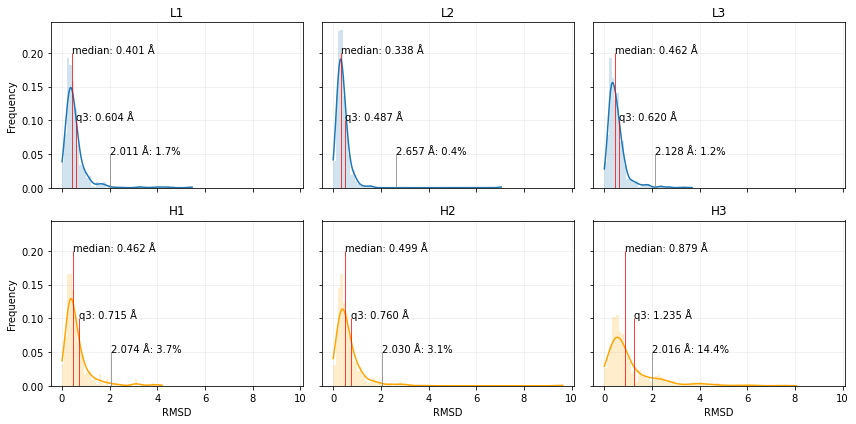

In [41]:
# initiate subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.flatten()

col_names = ['l_l1_rmsd', 'l_l2_rmsd', 'l_l3_rmsd', 'h_h1_rmsd', 'h_h2_rmsd', 'h_h3_rmsd', ]
bins = list(np.linspace(0, 5, 50))
sns_kwargs = dict(bins=bins, kde=True, alpha=0.2, edgecolor=None)

# subplots
for i, c in enumerate(col_names):
    ax = axes[i]
    if i < 3:  # light chain coluor blue
        sns.histplot(ub_df_filtered_wt, x=c, label=c, weights=ub_df_filtered_wt.weights, ax=ax, **sns_kwargs)
    else: # heavy chain colour orange
        sns.histplot(ub_df_filtered_wt, x=c, label=c, weights=ub_df_filtered_wt.weights, ax=ax, color='orange', **sns_kwargs)

    # annotate median
    median = np.quantile(ub_df_filtered_wt[c], .5)
    ax.vlines(x=median, ymin=0, ymax=.20, color='red', linewidth=0.75)
    ax.annotate(f'median: {median:.3f} Å', xy=(median, 0.20))

    # annotate q3
    q3 = find_weighted_quantile(ub_df_filtered_wt, c, .75)
    ax.vlines(x=q3, ymin=0, ymax=.10, color='red', linewidth=0.75)
    ax.annotate(f'q3: {q3:.3f} Å', xy=(q3, 0.10))

    # annotate 2.0 Angstrom
    boundary, percentile = find_thr_percentile(ub_df_filtered_wt, c, 2.0)
    ax.vlines(x=boundary, ymin=0, ymax=.05, color='grey', linewidth=0.75)
    ax.annotate(f'{boundary:.3f} Å: {(1-percentile)*100:.1f}%', xy=(boundary, 0.05))

    # other settings
    ax.grid(alpha=0.2); ax.set_ylabel('Frequency'); ax.set_xlabel('RMSD'); ax.set_title(c.upper()[2:4])

# beautify
fig.tight_layout()
fig.show()

save figures

In [44]:
# save fig
save_fig_name = 'CDR_RMSD.FittedHeavyOrLightChainFR'
od = os.path.join(OUT, "plots"); os.makedirs(od, exist_ok=True)
fig.savefig(os.path.join(od, f"{save_fig_name}.png"), dpi=300, transparent=True)
fig.savefig(os.path.join(od, f"{save_fig_name}.pdf"), transparent=True)

## Number of residues of each CDR loop
ub_df_filtered_wt

/var/folders/30/6ssmg8zn4179tmb1j89fkg5h0000gn/T/ipykernel_14703/2827541673.py:10: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



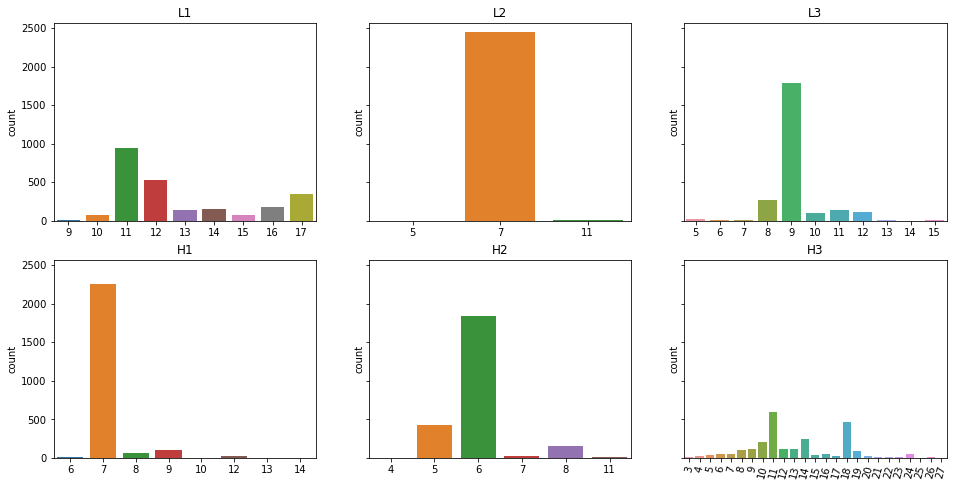

In [45]:
fig, axes = plt.subplots(2,3,figsize=(16, 8), sharey=True)
axes = axes.flatten()
for i, c in enumerate('l1,l2,l3,h1,h2,h3'.split(',')):
    ax = axes[i]
    sns.countplot(data=ub_df, x=f'{c}_num_atm_aln', ax=ax)
    ax.set_title(c.upper())
    ax.set_xlabel('')

axes[-1].set_xticklabels(np.arange(3, 28), rotation=75)
fig.show()

save figure

In [47]:
fig.savefig(os.path.join(OUT, 'plots', 'length_of_CDRs.pdf'), transparent=True)
fig.savefig(os.path.join(OUT, 'plots', 'length_of_CDRs.png'), transparent=True, dpi=300)

- L1: 11
- L2: 7
- L3: 9
- H1: 7
- H2: 6
- H3: 11, 14, 18